**Note:** If you get any errors due to packages not being installed, please add them to the cell below. 

In [1]:
#!pip3 install gym

import gym
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

from IoTgraph import IoTgraph

## 1. Training

In [2]:
# Classification labels
NOT_MAL = 0
MAL = 1
DEAD_END = 2

# Controls some print statements for debugging
verbose = False

Create and render an instance of the `IoTgraph` class. 

Reminder on convention:
* `env.src` = Node 0
* `env.dst` = Highest numbered node

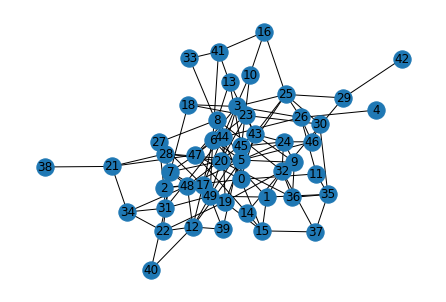

In [3]:
env = IoTgraph(network_size=50, edge_prob=0.1, percent_mal=0.3, attack_probs=[0.2, 0.8])
#env = IoTgraph('./env/env1.txt')

env.render()

Create lists of the intermediate nodes and their true labels.

In [4]:
int_nodes = list(range(1, env.dst))
labels_real = []
attack_probs = []

for a in env.devices:
    if a.node == env.src or a.node == env.dst:
        continue
    
    if a.mal:
        labels_real.append(MAL)
        
        if verbose:
            print(f'Node {a.node} IS malicious. Attack probability is {a.attack_prob:.2f}.')
    else:
        labels_real.append(NOT_MAL)
        
        if verbose:
            print(f'Node {a.node} is NOT malicious.')
            
    attack_probs.append(a.attack_prob)
            
print(int_nodes)
print(labels_real)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]


Some hyperparameters we introduce when we move to a RL environment:
* `corrupted_path_penalty` refers to the penalty our algorithm incurs when it takes a path that is corrupted. Setting this value is a choice; in this cell, we have made it equal to `env.network_size`, which means that a corrupted path is as bad or worse than the longest path in the network.
* `dead_end_penalty` refers to the penalty our algorithm incurs when it encounters a dead-end node. We don't need to consider this node for future pathfinding, so we put a high penalty on it. When we encounter a dead-end node, we don't ever want to visit it again. For this reason, we need to make the `dead_end_penalty` higher than any total penalty that could be incurred along a single path (since our Q-table keeps track of the **average** penalty for each node). The highest penalty would be a corrupted path that uses every single node in the network (`env.network_size + corrupted_path_penalty`). We multiply this by 2 just so the dead end nodes stand out more in the Q-table.
* `training_iterations` refers to the number of times we will try to find a path from the source to the destination. Too few iterations will lead to underfitting; too many will lead to overfitting.

The other hyperparameters are used for the Q-learning algorithm (definitions used from the [RL tutorial source](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)):
* `alpha` is the learning rate (0 < $\alpha$ <= 1). This captures the extent to which the Q-values are updated from one training iteration.
* `gamma` is the discount factor (0 < $\gamma$ <= 1). $\gamma$ determines how much importance we want to give to future rewards. A lower $\gamma$ makes our algorithm consider immediate rewards more, while a higher $\gamma$ captures a long-term effective reward.
* `epsilon` is the degree (0 < $\epsilon$ <= 1) to which we want to explore the action space (i.e. pick a random value) or exploit our learned Q-values. A lower $\epsilon$ will result in more penalties during training because we are more often picking new, unexplored paths. A higher $\epsilon$ will result in fewer penalties during training but may lead to overfitting.

In [5]:
training_iterations = 100000
rho_cp = 5 * env.network_size
rho_de = 2 * env.network_size

alpha = 0.05
gamma = 0.5
epsilon = 0.1

total_changes = 0

Initialize the Q table. Additionally, go through and find all of the nodes that don't connect to each other. Set these to -$\infty$, so we do not select these actions when training. Since our algorithm does not find cyclic paths (using the same node twice) and always ends when it reaches the destination, we will also set any pairs ending in the source or beginning with the destination to -infinity. The algorithm will never touch these values anyway, but it makes for a more clear Q-table.

In [6]:
q_table = np.zeros([env.num_states, env.num_actions])

for state in range(0, len(q_table)):
    possible_actions = list(range(0, len(q_table)))
    
    valid_neighbors = list(env.graph.neighbors(state))
    
    for action in possible_actions:
        action = int(action)
        if action not in valid_neighbors:
            q_table[state][action] = -np.Inf
       
q_table[:, env.src] = -np.Inf
q_table[env.dst, :] = -np.Inf
            
print(q_table)

[[-inf -inf   0. ...   0. -inf -inf]
 [-inf -inf -inf ... -inf -inf   0.]
 [-inf -inf -inf ... -inf   0. -inf]
 ...
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf   0. ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]]


Train the algorithm. Some notes about this cell, because it is the most complicated cell in the notebook:
* We are trying to find paths from the source to the destination, and we go one node at a time. Think of the current state as the node we are currently at. The possible actions we can choose from are the other nodes that we can visit from this node (so, its neighbors). However, this is at odds with how we define the Q-table, where all actions are technically "valid" from each state. For this reason, we keep a `valid_neighbors` array to reference when we select an action. If a node is a dead end, it will have no valid neighbors and we can stop the training iteration. 
* When we are finding paths from the source to the destination, we don't want to visit the same node twice (this is called a cycle and can easily lead to infinite loops). We use the `VISITED` flag and `visit_arr` to mark whether we've visited a node in the current pathfinding iteration. This also helps us when we look at the `valid_neighbors` of a node. 

In [7]:
VISITED = -1
times_visited = np.zeros([env.num_states, env.num_actions])

# For plotting metrics
epoch_batch = []
penalty_batch = []
batch_changes = 0

for i in range(1, training_iterations+1):
    
    # A batch is 1% of training iterations
    # Accumulate the total changes to the Q-table for the entire batch to use for plotting
    pct = (100 * i / training_iterations)
    if pct % 1 == 0:
        epoch_batch.append(pct)
        penalty_batch.append(batch_changes)
        batch_changes = 0
    
    
    # Initialize everything needed for a single iteration
    total_penalty = 0                       # Total penalty for single iteration
    state = env.src                         # Current node
    prev_state = env.src                    # Previous node (useful for penalizing dead ends)
    path = []                               # The path we're taking in this iteration
    visit_arr = np.zeros(env.network_size)  # The nodes we've visited on this path
    done = False                            # Done = reached env.dst or hit a dead end

    
    while not done:
        path.append(state)
        dead_end = True
        visit_arr[state] = VISITED
        
        # The neighbors are the possible valid actions; make sure at least one has not yet been visited
        # Otherwise, the current node is a dead end
        valid_neighbors = list(env.graph.neighbors(state))
        for neighbor in valid_neighbors:
            if visit_arr[neighbor] != VISITED:
                dead_end = False
                
        
        # The node is a dead end, so we penalize it and end this iteration
        if dead_end:
            q_table[prev_state, state] = -rho_de
            batch_changes += rho_de
            done = True

            
        # The node is not a dead end, so we select the next node to move to 
        else:  
            
            # Explore the action space by picking the next node randomly
            # Make sure the selected action is valid (check against visit_arr and valid_neighbors)
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
                while action not in valid_neighbors or visit_arr[action] == VISITED:
                    action = env.action_space.sample()
            
            # Exploit learned values by picking the best next node from the current node based on our Q-table
            # Make sure the selected action is valid (check against visit_arr and valid_neighbors)
            else:
                slc = q_table[state]
                action = np.argmax(slc)               

                valid_action_exists = False
                for neighbor in valid_neighbors:
                    if visit_arr[action] != VISITED:
                        valid_action_exists = True
                
                if valid_action_exists:
                    while action not in valid_neighbors or visit_arr[action] == VISITED:
                        slc[action] = -np.Inf # Doing this helps prevent backtracking
                        action = np.argmax(slc)
                
                else:
                    q_table[prev_state, state] = -rho_de
                    batch_changes += rho_de
                    done = True
                    
            # We've selected the next node to move to
            next_state = action
            prev_state = state
            state = next_state

            if state == env.dst:
                path.append(state)
                done = True
                
            total_penalty += 1
    
    # Print out the path we took.
    # If we got to the destination, determine if that path was corrupted. Update the reward accordingly
    if verbose:
        print(f'Path taken = {path}.')
            
    # The path is corrupted, so we add rho_cp to the total penalty for this iteration
    if env.is_corrupted(path):
        total_penalty += rho_cp
        batch_changes += total_penalty

    # Penalize each intermediate node along the path equally based on the total penalty for the iteration
    # The times_visited array is used to keep the penalties normalized (average penalty)
    for state in path[0:len(path)-2]:
        action = path[path.index(state)+1]
        visits = times_visited[state, action]
        if visits == 0:
            q_table[state, action] -= total_penalty

        else:
            avg_penalty = (q_table[state, action] * visits - total_penalty) / (visits + 1)
            q_table[state, action] = avg_penalty

        times_visited[state, action] += 1

Path = [0, 15, 1, 6, 41] is corrupted
Node 41 attacked this path
Path = [0, 43, 9, 5, 6, 1, 15, 14] is corrupted
Node 14 attacked this path
Path = [0, 44, 10, 16] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 6, 5, 8] is corrupted
Node 10 attacked this path
Path = [0, 47, 3, 20] is corrupted
Node 3 attacked this path
Path = [0, 2, 31] is corrupted
Node 31 attacked this path
Path = [0, 11, 26, 3, 20] is corrupted
Node 20 attacked this path
Path = [0, 11, 35, 37, 32, 1] is corrupted
Node 32 attacked this path
Path = [0, 11, 26, 3, 25] is corrupted
Node 3 attacked this path
Path = [0, 2, 7, 18, 3, 25] is corrupted
Node 3 attacked this path
Path = [0, 11, 26, 3] is corrupted
Node 3 attacked this path
Path = [0, 11, 26, 25, 3] is corrupted
Node 25 attacked this path
Path = [0, 11, 26, 46, 5, 24, 9, 36, 20, 3] is corrupted
Node 46 attacked this path
Path = [0, 11, 26, 44, 31, 2, 27, 7, 20] is corrupted
Node 31 attacked this path
Path = [0, 11, 26, 3] is corrupted
Node 3 

Path = [0, 45, 10, 44, 33, 41, 6, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 2, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 11, 35, 36, 9, 24, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 12, 49] is corrupted
Node 39 attacked this path
Path = [0, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 43, 13, 8, 5, 48, 2, 7, 49] is corrupted
Node 48 attacked this path
Path = [0, 11, 35, 36, 9, 24, 46] is corrupted
Node 46 attacked this path
Path = [0, 15, 37, 35, 30, 46, 24, 5, 19, 22, 12, 39, 49] is corrupted
Node 46 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Pat

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 19, 22, 12, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 19, 5] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 19, 5] is corrupted
Node 10 attacked this path
Path = [0, 2, 7, 22, 12, 39, 45, 10, 44, 19, 5] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 47, 14, 15, 37, 35, 1, 49] is corrupted
Node 14 attacked this path
Path = [0, 45, 10, 44, 19, 5] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 19, 5] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 19, 5] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 19, 

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 16, 41, 6, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 43, 25, 30, 46] is corrupted
Node 25 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 13, 43, 2

Path = [0, 45, 10, 44, 19, 22, 7, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 19, 22, 7, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 19, 22, 34] is corrupted
Node 10 attacked this path
Path = [0, 2, 7, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 45, 10, 44, 19, 22, 7, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 19, 22, 7, 49] is corrupted
Node 10 attacked this path
Path = [0, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 43, 23, 30, 25, 3, 18, 7, 49] is corrupted
Node 25 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 45, 24, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 45, 10, 44, 26, 3, 20, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 

Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 44, 33] is corrupted
Node 33 attacked this path
Path = [0, 45, 10, 44, 33] is corrupted
Node 10 attacked this path
Path = [0, 44, 10, 16, 41, 13, 43, 9] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 44, 33, 41] is corrupted
Node 41 attacked this path
Path = [0, 45, 10, 44, 33, 41] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 12, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 31, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 14, 47, 6, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 16, 41, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 44, 17, 15, 1, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 44, 10, 45, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 13, 8, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0,

Path = [0, 2, 48, 7, 49] is corrupted
Node 48 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 44, 33, 41] is corrupted
Node 33 attacked this path
Path = [0, 11, 35, 36, 9, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 27, 7, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 12, 48, 43, 23, 47, 6, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 24, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 44, 33, 41] is corrupted
Node 33 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 26, 4] is corrupted
Node 10 attacked this path
Path = [0, 

Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 26, 4] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 43, 23, 47, 3] is corrupted
Node 3 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 13, 41, 33] is corrupted
Node 33 attacked this path
Path = [0, 45, 10, 16, 41, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 44, 10] is corrupted
Node 1

Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 16, 41, 33, 44, 19, 32] is corrupted
Node 10 attacked this path
Path = [0, 45, 13, 8, 27, 7, 48, 2] is corrupted
Node 48 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 11, 35, 1, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 45, 10, 44, 17, 12, 22] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] i

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 14] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 37, 35, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 6, 47] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 31, 49] is corrupted
Node 10 attacked this path
Path = [0, 43, 25, 30, 46] is corrupted
Node 46 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 44, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 45, 10, 44, 31, 49] is corrupted
Node 10 attacked this path
Path = 

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 43, 25, 30, 46] is corrupted
Node 25 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 43, 13, 8, 27, 7, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 13, 8, 27, 7, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 37, 35, 30, 46] is corrupted
Node 10 attacked this path
Path = [0, 45, 39

Path = [0, 45, 10, 44, 17, 15, 1, 35] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33, 41, 16] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 27, 8] is corrupted
Node 10 attacked this path
Path = [0, 45, 13, 8, 27, 7, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 44, 33, 41, 16] is corrupted
Node 33 attacked this path
Path = [0, 45, 10, 44, 17, 12, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 13, 8, 27, 7, 20, 49] is corrupted
Node 20 attacked this path
Path = [0, 45, 10, 44, 17, 6, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this 

Path = [0, 45, 10, 44, 17, 15, 1, 32, 19] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 13, 8, 5, 19, 32] is corrupted
Node 32 attacked this path
Path = [0, 45, 13, 8, 32, 19] is corrupted
Node 32 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 32, 19] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 6, 49] is corrupt

Path = [0, 45, 10, 44, 17, 12, 49] is corrupted
Node 10 attacked this path
Path = [0, 43, 13, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 37, 35, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 44, 26, 46, 30] is corrupted
Node 46 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 35] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this p

Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 13, 41, 16] is corrupted
Node 41 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 6, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 33, 41, 16, 25, 30, 46] is corrupted
Node 10 attacked this path
Path = [0, 2, 31, 49] is corrupted
Node 31 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 13, 41, 16, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 19, 32] is 

Path = [0, 45, 39, 12, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 12, 5] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 27, 7, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 6, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 16, 41, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Pa

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 19, 32] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 43, 23, 47, 3, 20, 49] is corrupted
Node 3 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 16, 41] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 47, 3, 20, 49] is corrupted
Node 3 attacked this path
Path = [0, 45, 10, 44, 17, 15, 1, 49] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupte

Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 44, 33, 41] is corrupted
Node 41 attacked this path
Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 16, 41, 33] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 24, 46, 26, 4] is corrupted
Node 46 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 2, 7, 48, 43, 23, 47, 6, 49] is corrupted
Node 48 attacked this path
Path = [0, 45, 13, 41, 33] is corrupted
Node 41 attacked this path
Path = [0, 45, 10, 44] is corrupted
Nod

Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 44, 10] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this path
Path = [0, 45, 39, 49] is corrupted
Node 39 attacked this path
Path = [0, 45, 10, 44] is corrupted
Node 10 attacked this p

## 2. Classification


Move the Q-table to a DataFrame and (optionally) print it out. 

In [8]:
q_table_df = pd.DataFrame(q_table)

if verbose:
    print(f'Corrupted path penalty is {rho_cp}.')
    print(f'Dead end penalty is {rho_de}.')
    print('\n')
    print(q_table_df)

Use the columns of the Q-table to classify each corresponding intermediate node.

If all finite values in a column $= \rho_{de}$, the node is a dead end regardless of the path taken. These nodes are ignored from classification.

For all remaining columns, use the following criteria to classify the corresponding node as malicious or benign:
* If the maximum value of the column is $ > \rho_{de} $, the node is benign.
* If the maximum value of the column is $ \leq \rho_{de} $, the node is malicious.

In [9]:
labels_pred = []

for name, data in q_table_df.iteritems():
    if name == env.src or name == env.dst:
        continue

    col_max = max(data.values)
    append_one = False
    
    if col_max > -rho_de:
        labels_pred.append(NOT_MAL)
    
    elif col_max == -rho_de:
        for val in data.values:
            if val > -np.inf and val < -rho_de:
                append_one = True
                break
        
        if append_one:
            labels_pred.append(MAL)
        else:
            labels_pred.append(DEAD_END)
        
    else:
        labels_pred.append(MAL)

X = []
y_pred = []
y_hat = []

for x, y_p, y_h in zip(int_nodes, labels_pred, labels_real):
    if y_p != DEAD_END:
        X.append(x)
        y_pred.append(y_p)
        y_hat.append(y_h)

if verbose:
    print(X)
    print(y_pred)
    print(y_hat)

## 3. Analysis

Now that we have classified each intermediate node and ignored the dead end nodes, we can compute the accuracy, precision, and recall of the classifications.

In [10]:
print(f'Accuracy: {accuracy_score(y_hat, y_pred):.2f}.')
print(f'Precision: {precision_score(y_hat, y_pred):.2f}.')
print(f'Recall: {recall_score(y_hat, y_pred):.2f}.')

print(confusion_matrix(y_hat, y_pred))

Accuracy: 0.80.
Precision: 0.67.
Recall: 0.71.
[[25  5]
 [ 4 10]]


We can also show how the algorithm converges over the course of a simulation runs, using the `batch_changes` that we kept track of.

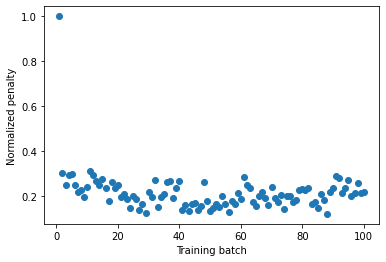

In [11]:
penalty_batch = [x / max(penalty_batch) for x in penalty_batch]
plt.scatter(epoch_batch, penalty_batch)
plt.xlabel('Training batch')
plt.ylabel('Normalized penalty')
plt.show()